# Talking Data

In [15]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import time
import random
import tarfile
import zipfile
#import StringIO
from IPython.display import display, Image

from sklearn.preprocessing import LabelEncoder
#from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,MeanShift
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score


datadir="./data/TalkingData/"

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

### some function def

In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

In [3]:
   
def runPredict(clf,data, display=True):
    index=random.randrange(len(data))
    y_pred = clf.predict(data[index].reshape(1, -1))[0]
    if display==True:
        print "for:",data[index], "prediction:",y_pred
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=1000,C=1e-5)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Import data

In [121]:
# load up the data!
app_events = loadData(datadir,'app_events.csv.zip')
app_labels = loadData(datadir,'app_labels.csv.zip')
label_categories = loadData(datadir,'label_categories.csv.zip')

events = loadData(datadir,'events.csv.zip')
events['timestamp']=pd.to_datetime(events['timestamp'])


phone_brand_device_model = loadData(datadir,'phone_brand_device_model.csv.zip')
phone_brand_device_model.drop_duplicates('device_id',keep='first', inplace=True)

gender_age_train = loadData(datadir,'gender_age_train.csv.zip')
#gender_age_test = loadData(datadir,'gender_age_test.csv.zip')




loading: ./data/TalkingData/app_events.csv.zip
Dataset has 32473067 samples with 4 features each.
loading: ./data/TalkingData/app_labels.csv.zip
Dataset has 459943 samples with 2 features each.
loading: ./data/TalkingData/label_categories.csv.zip
Dataset has 930 samples with 2 features each.
loading: ./data/TalkingData/events.csv.zip
Dataset has 3252950 samples with 5 features each.
loading: ./data/TalkingData/phone_brand_device_model.csv.zip
Dataset has 187245 samples with 3 features each.
loading: ./data/TalkingData/gender_age_train.csv.zip
Dataset has 74645 samples with 4 features each.


### Create a location feature, and look at it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 124.1 MB


None

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 124.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 2 columns):
longitude    float64
latitude     float64
dtypes: float64(2)
memory usage: 49.6 MB


None

,longitude,latitude
0,121.38,31.24
1,103.65,30.97
2,106.60,29.70
3,104.27,23.28


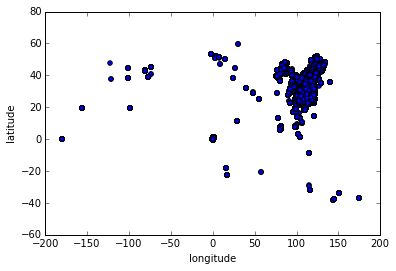

In [42]:
#cluster the locations in the event
display(events.info())
display(events.head(4))

locations=events.drop(['event_id','device_id','timestamp'],1)
display(locations.info())
display(locations.head(4))

locations.plot(kind='scatter',x='longitude',y='latitude')
plt.show()
plt.close()

In [49]:
# get many cluster centers of the data, for a large number of clusters
def kmeansPlusmeanshift(data):
    startingClusterSize=int(len(data)*.0005)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.2).values)
    clusters=k_means.cluster_centers_
    print clusters[:15]

    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)

    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    return final_clusters
    
    
final_clusters=kmeansPlusmeanshift(locations)
print "sample clusters after kmeans:\n ",final_clusters[:15]
    

kmeans.... for 162 clusters


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local

[[  1.26748362e+02   4.58390419e+01]
 [  4.39869061e-05   5.21448521e-06]
 [  1.13034240e+02   2.80738974e+01]
 [  1.16413484e+02   3.99444080e+01]
 [  1.20858017e+02   3.21759150e+01]
 [  1.04036983e+02   3.06906702e+01]
 [ -1.80000000e+02   3.55271368e-15]
 [  1.13225385e+02   2.30522173e+01]
 [  8.74301888e+01   4.35477970e+01]
 [  1.10880617e+02   3.50953405e+01]
 [ -7.76890476e+01   3.94449206e+01]
 [  1.16489343e+02   2.34589489e+01]
 [  1.23158788e+02   4.10462221e+01]
 [  1.16177928e+02   3.71013488e+01]
 [  1.21439497e+02   3.11769954e+01]]

meanshift...
[[  1.14146297e+02   3.29143917e+01]
 [  1.11154218e+02  -1.27902476e+01]
 [ -1.01165333e+02   2.91720000e+01]
 [ -7.57175794e+01   4.24810714e+01]
 [  5.11591996e+01   2.71224670e+01]
 [  4.99924387e-01   5.00024049e-01]
 [ -1.80000000e+02   3.55271368e-15]
 [ -1.55990000e+02   1.98200000e+01]
 [  1.65300000e+01  -2.02566667e+01]
 [  1.37034483e+00   5.27175862e+01]
 [  1.49665385e+02  -3.48661538e+01]
 [  2.85100000e+01   1.

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/usr/local

sample clusters after kmeans:
  [ 4  8  8  8  5  1 10  2  1  3  2  2 11  5  4]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 6 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
location     int32
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2)
memory usage: 136.5 MB


None

,event_id,device_id,timestamp,longitude,latitude,location
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,4
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,8
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,8
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,8
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,5
5,6,1476664663289716375,2016-05-01 00:27:21,0.00,0.00,1
6,7,5990807147117726237,2016-05-01 00:15:13,113.73,23.00,10
7,8,1782450055857303792,2016-05-01 00:15:35,113.94,34.70,2
8,9,-2073340001552902943,2016-05-01 00:15:33,0.00,0.00,1
9,10,-8195816569128397698,2016-05-01 00:41:31,119.34,26.04,3


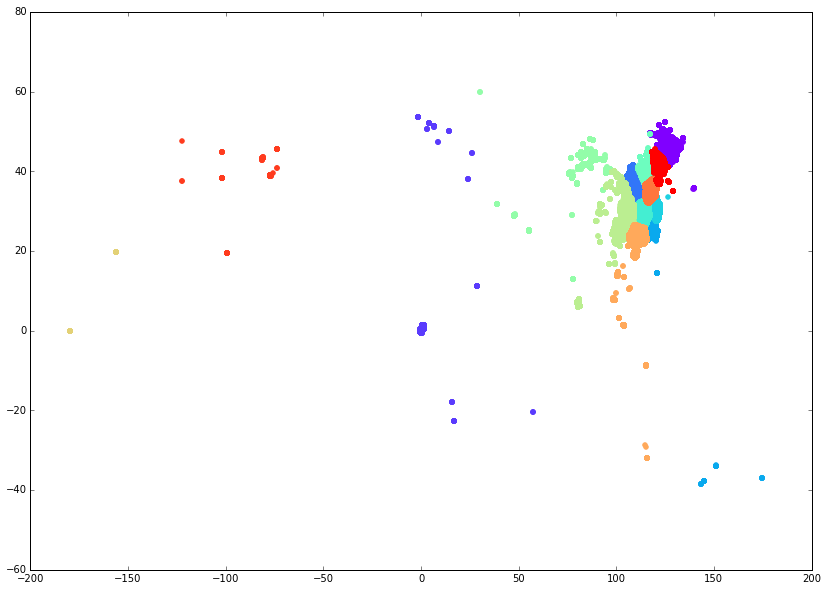

In [55]:
events['location']=final_clusters
display(events.info())
display(events.head(10))

numlocationclusters=len(np.unique(final_clusters))

plt.figure(figsize=(14,10))
colors = cm.rainbow(np.linspace(0, 1, numlocationclusters))

for cluster in range(numlocationclusters):
    plt.scatter(events[events['location']==cluster]['longitude'],
             events[events['location']==cluster]['latitude'],
             color=colors[cluster])
             #color=colors[locations[locations['cluster']==cluster]['cluster']])
        
plt.show()
plt.close()

### Create a time feature

In [123]:

#times=events['timestamp']
display(events.info())
display(events.head(5))

events_timeindex=events.set_index('timestamp')
#display(events_timeindex.info())
#display(events_timeindex.head(5))

events["hour"] = events_timeindex.index.hour
events["day"] = events_timeindex.index.day
print "unique days",events["day"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 124.1 MB


None

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


unique days [ 1 30  2  3  4  5  6  7  8]


### take the new created features into a new setting, leaving the original as it was.

In [101]:
events_featured=events.drop(["timestamp",'longitude','latitude'],1) 
events.drop(["location",'hour','day'],1) 

display(events.sample(frac=0.2).head(5))
display(events_featured.sample(frac=0.2).head(5))
display(events_featured.info())


,event_id,device_id,timestamp,longitude,latitude,location,hour,day
2433823,2433824,7068538169707500106,2016-05-02 18:29:23,121.90,30.89,4,18,2
1422898,1422899,-6542990369714353997,2016-05-06 10:48:51,113.48,23.59,10,10,6
824996,824997,-7729963400062496821,2016-05-03 19:13:12,0.00,0.00,1,19,3
1846519,1846520,-5981727240500340157,2016-05-05 07:42:33,114.36,34.83,2,7,5
61899,61900,-401485661591799822,2016-05-07 22:11:30,120.27,30.32,4,22,7


,event_id,device_id,location,hour,day
1551912,1551913,9210091097295258426,1,15,2
1422991,1422992,6490545117356683029,10,10,7
679731,679732,-7391479759493143154,1,14,3
221952,221953,3736318695081462994,1,9,7
3092381,3092382,6350279684219465691,6,9,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
event_id     int64
device_id    int64
location     int32
hour         int32
day          int32
dtypes: int32(3), int64(2)
memory usage: 86.9 MB


None

In [118]:
# from https://www.kaggle.com/agavranis/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/code
# Data - Events data
# Bag of apps
print("# Read app events")
app_events = pd.read_csv(os.path.join(datadir,'app_events.csv'), dtype={'device_id' : np.str})
app_events.head(5)
app_events.info()
#print(rstr(app_events))




# Read app events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtypes: int64(4)
memory usage: 991.0 MB
# Read Events
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488096 entries, 1 to 3252947
Data columns (total 5 columns):
device_id    1488096 non-null int64
app_id       1488096 non-null object
location     1488096 non-null int32
hour         1488096 non-null int32
day          1488096 non-null int32
dtypes: int32(3), int64(1), object(1)
memory usage: 51.1+ MB


In [122]:

# remove duplicates(app_id)
app_events= app_events.groupby("event_id")["app_id"].apply(
    lambda x: " ".join(set("app_id:" + str(s) for s in x)))
app_events.head(5)

print("# Read Events")
#events = pd.read_csv(os.path.join(datadir,'events.csv'), dtype={'device_id': np.str})
events_featured.head(5)
events_featured["app_id"] = events_featured["event_id"].map(app_events)
events_featured = events_featured.dropna()


events_featured = events_featured[["device_id", "app_id", 'event_id''location', 'hour','day']]
events_featured.info()
events_featured.head(4)
# 1Gb reduced to 34 Mbevents_featured.head(5)

# Read Events


KeyError: 'event_id'

In [ ]:
del app_events

### start merging with the training data

In [102]:
# just events related to devices in training:
display(gender_age_train.info())
display(gender_age_train.head(4))

print ("merging: events_featured")
train_events = gender_age_train.merge(events_featured, how='left', on='device_id')
train_events.drop(['gender','age'],1, inplace=True)
display(train_events.info())
display(train_events.head(4))

print ("merging: phone_brand_device_model")
train_events = train_events.merge(phone_brand_device_model, how='left', on='device_id')
display(train_events.info())
display(train_events.head(4))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
device_id    74645 non-null int64
gender       74645 non-null object
age          74645 non-null int64
group        74645 non-null object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


None

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31


merging: events_featured
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1266931 entries, 0 to 1266930
Data columns (total 6 columns):
device_id    1266931 non-null int64
group        1266931 non-null object
event_id     1215595 non-null float64
location     1215595 non-null float64
hour         1215595 non-null float64
day          1215595 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 67.7+ MB


None

,device_id,group,event_id,location,hour,day
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN
2,-8260683887967679142,M32-38,2479656.0,1.0,14.0,1.0
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN


merging: phone_brand_device_model
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1266931 entries, 0 to 1266930
Data columns (total 8 columns):
device_id       1266931 non-null int64
group           1266931 non-null object
event_id        1215595 non-null float64
location        1215595 non-null float64
hour            1215595 non-null float64
day             1215595 non-null float64
phone_brand     1266931 non-null object
device_model    1266931 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 87.0+ MB


None

,device_id,group,event_id,location,hour,day,phone_brand,device_model
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,小米,MI 2
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,小米,MI 2
2,-8260683887967679142,M32-38,2479656.0,1.0,14.0,1.0,小米,MI 2
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,小米,红米note


In [108]:
display(train_events.info())
display(train_events.head(4))

display(events[events['device_id']==-8260683887967679142])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1266931 entries, 0 to 1266930
Data columns (total 8 columns):
device_id       1266931 non-null int64
group           1266931 non-null object
event_id        1215595 non-null float64
location        1215595 non-null float64
hour            1215595 non-null float64
day             1215595 non-null float64
phone_brand     1266931 non-null object
device_model    1266931 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 87.0+ MB


None

,device_id,group,event_id,location,hour,day,phone_brand,device_model
0,-8076087639492063270,M32-38,NaN,NaN,NaN,NaN,小米,MI 2
1,-2897161552818060146,M32-38,NaN,NaN,NaN,NaN,小米,MI 2
2,-8260683887967679142,M32-38,2479656.0,1.0,14.0,1.0,小米,MI 2
3,-4938849341048082022,M29-31,NaN,NaN,NaN,NaN,小米,红米note


,event_id,device_id,timestamp,longitude,latitude,location,hour,day
2479655,2479656,-8260683887967679142,2016-05-01 14:23:37,0.0,0.0,1,14,1


In [ ]:
events["app_id"] = events["event_id"].map(app_events)
events = events.dropna()
del app_events

events = events[["device_id", "app_id"]]
events.info()

### older tries at data...

In [36]:
label_categories.drop_duplicates('label_id',keep='first', inplace=True)
display(app_labels.head(5))
display(label_categories.head(5))

print ("size of app_labels:",len(app_labels))

category=pd.Series([])
for i in range(10000):#len(app_labels)):
    category[i]=label_categories[label_categories['label_id']==app_labels.loc[i].label_id].category.values[0]
    if i%10000 == 0:
        print(i,category.loc[i])
        
app_labels['category']= category
display(app_labels.head(6))

,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown
3,6058196446775239644,407,DS_P2P net loan
4,8694625920731541625,406,unknown


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


('size of app_labels:', 459943)
(0, 'Finance')


,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown
3,6058196446775239644,407,DS_P2P net loan
4,8694625920731541625,406,unknown
5,8694625920731541625,407,DS_P2P net loan


In [ ]:


# the ONE TABLE to rule them all

print ("merging: events")
df = gender_age_train.merge(events, how='left', on='device_id')
print ("merging: phone_brand_device_model")
df = df.merge(phone_brand_device_model, how='left', on='device_id')

print ("merging: phone_brand_device_model")
df = df.merge(app_events, how='left', on='event_id')

print ("merging: app_labels")
df = df.merge(app_labels, how='left', on='app_id')
print ("merging: label_categories")
df=  df.merge(label_categories, how='left', on='label_id')


#df=df.fillna(0)

#brandLE = LabelEncoder().fit(df.phone_brand)
#df['phone_brand'] = brandLE.transform(df['phone_brand'])
#modelLE = LabelEncoder().fit(df.device_model)
#df['device_model'] = modelLE.transform(df['device_model'])
#groupLE = LabelEncoder().fit(df.group)
#df['group'] = groupLE.transform(df['group'])
#categoryLE = LabelEncoder().fit(df.category)
#df['category'] = categoryLE.transform(df['category'])
#app_idLE = LabelEncoder().fit(df.app_id)
#df['app_id'] = app_idLE.transform(df['app_id'])

df.info()
display (df.head(5))
df=df.drop(['gender','age', 'event_id', 'label_id','is_installed','is_active', 'event_id', 'timestamp','device_id', 'longitude','latitude' ],1)
display(df.info())
display(df.head(5))

    

In [ ]:
curr_app_id=df.loc[3].app_id

print(df[df.app_id==curr_app_id].head(10))
print(app_labels[app_labels.app_id==curr_app_id])


In [ ]:
app_idLE.inverse_transform(6854)
display(app_idLE.inverse_transform(3514))

display(app_labels[app_labels['app_id']==app_idLE.inverse_transform(3514)])

categoryLE.inverse_transform(713)
categoryLE.inverse_transform(704)

In [ ]:
display (df.head(2))

counterCat=0
counterApp=0
for i in range(len(df)):
    if df.loc[i].category!=0:
        counterCat+=1
    if df.loc[i].app_id!=0:
        counterApp+=1
        
    if i % 100000 ==0:
        print (i, "category:",df.loc[i].category, counterCat,"App:",df.loc[i].app_id, counterApp)
print("counter:",counter)

### Split data intro train/test, train a classifier

In [ ]:

x=df.drop('group',1)
y=df['group']

display(x.head(2))
display(y.head(2))


In [ ]:
#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.25, random_state=42)

dataSize=X_train.shape[0]
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

#test_sizes=[63,630,6300,31500]
#test_sizes=[50,500,5001]
print ("run tests of size",test_sizes)

In [ ]:
display (X_train[0], y_train[0])
display (x[0],y[0])

In [ ]:
print ("Logistic:")
clf=runTests(test_sizes, X_train,y_train,X_test,y_test)
print("Validation Prediction is:",runPredict(clf,X_test))

In [ ]:
print ("AdaBoost:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier())
print("Validation Prediction is:",runPredict(clf,X_test))

In [ ]:
print("Validation Prediction is:",runPredict(clf,X_test))

### EOF